In [1]:
import gym, recogym
from recogym import env_1_args
import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial
from recogym.agents import OrganicUserEventCounterAgent, organic_user_count_args
from recogym import Configuration

%matplotlib inline

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 3]

num_users =100
num_products =10
num_samples = 20

env_1_args['phi_var']=0.0
env_1_args['number_of_flips']=10
env_1_args['sigma_mu_organic'] = 2
env_1_args['sigma_omega']=0
env_1_args['random_seed'] = 42
env_1_args['num_products'] = num_products
env_1_args['K'] = 5
env_1_args['number_of_flips'] = 3
env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)
data = env.generate_logs(num_users)

## Testen zonder klasses etc.

## Creating the agent

In [19]:
from numpy.random import choice
from recogym.agents import Agent

# Define an Agent class.

class NearestNeighbourAgent(Agent):
    def __init__(self, config):
        # Set number of products as an attribute of the Agent.
        super(NearestNeighbourAgent, self).__init__(config)

        # Track number of times each item viewed in Organic session.
        self.M_organic=np.empty((0,self.config.num_products))
        
        #Track number of times each item viewed in bandit
        self.M_bandit_clicks=np.empty((0,self.config.num_products))
        self.M_bandit_attempts=np.empty((0,self.config.num_products))
        self.weight_organic=0.01
        self.weight_bandit=0.99
        self.k=5

    def train(self, observation, action, reward, done):
        """Train method learns from a tuple of data.
            this method can be called for offline or online learning"""

        # Adding organic session to organic view counts.
        print(1)
        if not observation:
            return
        for session in observation.sessions():
            if session['z']=='organic':
                if session['u']>self.M_organic.shape[0]:
                    self.M_organic=np.vstack((self.M_organic, np.zeros((1,self.config.num_products))))
                self.M_organic[session['u'],session['v']] += 1
            else:
                if session['u']>self.M_bandit_clicks.shape[0]:
                    self.M_bandit_clicks=np.vstack((self.M_bandit_clicks, np.zeros((1,self.config.num_products))))
                if session['c']>0.5:
                    self.M_bandit_clicks['u']['a']+=1
                if session['u']>self.M_bandit_attempts.shape[0]:
                    self.M_bandit_attempts=np.vstack((self.M_bandit_attempts, np.zeros((1,self.config.num_products))))
                self.M_bandit_attempts[session['u'],session['a']] += 1
                
    def find_kNN_organic(self, user_organic):
        total_organic=np.sum(self.M_organic, 1)
        scaled_organic_M=self.M_organic/total_organic[:,None]
        tree = spatial.KDTree(scaled_organic_M)
        nearest_neighbours=tree.query(user_organic/sum(user_organic),self.k)
        return nearest_neighbours

    def pick_best_bandit(self, distances, neighbours):
        compl_sigmoid_distances=1-1/(1+np.exp(-distances))
        total_organic=np.sum(self.M_organic, 1)
        scaled_organic_M=self.M_organic/total_organic[:,None]
        M_bandit_CTR=self.M_bandit_clicks/self.M_bandit_attempts
        score_items=np.zeros(self.config.num_products)
        for j, neighbour in enumerate(neighbours):
            #Add to items for organic info
            score_items+=self.weight_organic*compl_sigmoid_distances[j]*scaled_organic_M[neighbour,:]

            #Add to items for Bandit information
            score_items+=self.weight_bandit*self.compl_sigmoid_distances[j]*M_bandit_CTR[neighbour,:]
        score_items=score_items/np.sum(score_items)
        return score_items

    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past
            history"""

        # Choosing action randomly in proportion with number of views.
        for session in observation.sessions():
            if session['u'] == 2:
                print(session)
                break
        #distances, neighbours = self.find_kNN_organic(user_organic)
        prob = np.zeros((self.config.num_products)) #self.pick_best_bandit(distances, neighbours)
        prob[1]=1
        action = choice(self.config.num_products, p = prob)

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action],
                'ps-a': prob
            }
        }
    
class GreedySingleActionAgent(Agent):
    def __init__(self, preferred_action, config = Configuration({'num_products': 10})):
        super(GreedySingleActionAgent, self).__init__(config)
        self.preferred_action = preferred_action
        
    def act(self, observation, reward, done):
        prob = np.zeros(self.config.num_products)
        prob[self.preferred_action] = 1.
        return {
            **super().act(observation, reward, done),
            **{
                'a': self.preferred_action,
                'ps': prob[self.preferred_action],
                'ps-a': prob,
            },
        }

In [20]:
from datetime import datetime
from recogym.evaluate_agent import verify_agents, plot_verify_agents

neigbour_agent = NearestNeighbourAgent(Configuration(env_1_args))

In [21]:
print('Starting A/B-testing at {0}'.format(datetime.now()))
result = verify_agents(env,
                       number_of_users = 20,
                       agents = {
                        'Nearest-Neighbour': neigbour_agent
                       })
print('Finished A/B-testing at {0}'.format(datetime.now()))

Starting A/B-testing at 2019-10-08 17:20:11.499367
{'t': 0, 'u': 2, 'z': 'pageview', 'v': 4}
{'t': 27, 'u': 2, 'z': 'pageview', 'v': 4}
{'t': 39, 'u': 2, 'z': 'pageview', 'v': 4}
{'t': 53, 'u': 2, 'z': 'pageview', 'v': 7}
{'t': 69, 'u': 2, 'z': 'pageview', 'v': 4}
{'t': 91, 'u': 2, 'z': 'pageview', 'v': 7}
{'t': 121, 'u': 2, 'z': 'pageview', 'v': 4}
{'t': 146, 'u': 2, 'z': 'pageview', 'v': 3}
{'t': 158, 'u': 2, 'z': 'pageview', 'v': 7}
{'t': 172, 'u': 2, 'z': 'pageview', 'v': 7}
{'t': 191, 'u': 2, 'z': 'pageview', 'v': 5}
{'t': 204, 'u': 2, 'z': 'pageview', 'v': 4}
Finished A/B-testing at 2019-10-08 17:20:11.947389


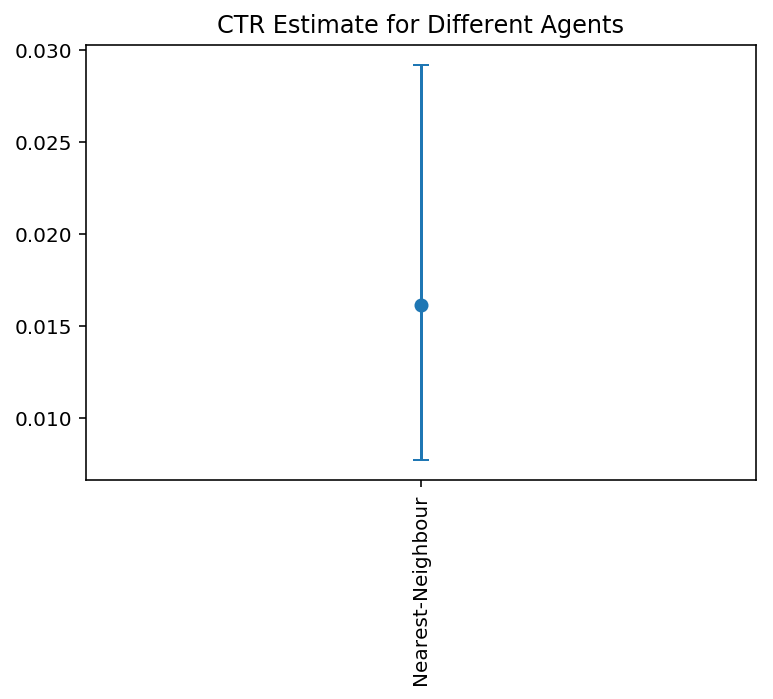

In [5]:
fig = plot_verify_agents(result)
plt.show()

In [6]:
import torch

In [7]:
M=np.zeros((2,2))
A=np.zeros((2))
tree = spatial.KDTree(M)
nearest_neighbours=tree.query(A,2)

In [53]:
nearest_neighbours

(array([0., 0.]), array([0, 1]))